In [1]:
using Pkg

Pkg.add("CSV")
Pkg.add("DataFrames")

using CSV, DataFrames, Plots

    Updating registry at `C:\Users\User 1\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\User 1\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\User 1\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User 1\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\User 1\.julia\environments\v1.7\Manifest.toml`

(process:21140): GLib-GIO-WARNING **: 09:14:18.891: Unexpectedly, UWP app `Microsoft.People_10.2105.4.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.People_8wekyb3d8bbwe!x4c7a3b7dy2188y46d4ya362y19ac5a5805e5x') supports 1 extensions but has no verbs


In [2]:
data=CSV.read("C:/Users/User 1/Downloads/testasset.csv",DataFrame)
data=coalesce.(data,0)
data=Matrix(data)

##Every thirty days
every_thirty=collect(1:30:length(data[:,1]))
data=data[every_thirty,:]

42×9 Matrix{Float64}:
 164.59   39.0      23.712    50.0465  …  34.1366   49.6      82.4   255.29
 172.33   43.7425   21.0367   59.3        34.0133   52.3705   84.07  262.87
 193.1    43.5825   22.246    62.635      34.6869   55.276    87.71  276.12
 185.47   43.125    23.078    74.267      35.1898   57.1875   87.14  277.9
 174.45   42.095    19.9533   70.2615     34.1082   51.582    83.24  265.15
 187.42   46.5775   18.4547   78.7185  …  33.8899   53.4865   84.56  272.61
 194.02   46.795    22.338    85.689      34.981    56.2135   83.66  273.11
 193.1    52.4375   23.176    95.9825     39.2979   60.3245   86.85  284.06
 207.52   55.105    20.6387   98.7425     41.8121   59.6735   87.09  290.72
 187.23   52.4875   23.2107   87.7745     42.0114   53.3075   85.75  277.76
 160.48   37.6825   21.318    68.8725  …  40.0285   51.973    76.62  246.18
 184.72   43.56     21.148    82.013      40.0664   54.753    83.0   270.47
 189.97   48.7725   18.268    90.963      39.7438   59.65     84.49

In [3]:
function Markowitz(assets,test_nums)
    
    a,b=size(assets)
    rate_ret=zeros(a-1,b)

    for i in 2:a
        rate_ret[i-1,:]=(assets[i,:] .-assets[i-1,:]) ./assets[i-1,:]
    end
        
    ##nan and inf section
    rate_ret=replace!(rate_ret,NaN=>0.0001)
    rate_ret=replace!(rate_ret,Inf=>0.0001)
    
    exp_assets=[sum(rate_ret[:,i])/(a-1) for i in 1:b]
  
    cov_matrix=zeros(b,b)

    for i in 1:b
        for j in 1:b
            cov_matrix[i,j]=sum((rate_ret[:,i] .-exp_assets[i]) .*(rate_ret[:,j] .-exp_assets[j]))/(a-1)
        end
    end
    
    
    returns=[]
    risks=[]
    all_weights=[]
    sharpe_score=[]
    
    ##30 day risk-free rate of return.
    r_f=.033
    
    for i in 1:test_nums
        weights=rand(b)
        weights=weights ./sum(weights)
        ret=sum(weights .*exp_assets)
        ris=sqrt(sum(sum(weights[x]*weights[y]*cov_matrix[x,y] for y in 1:b) for x in 1:b))
        if isnan(ret)==false
            if isnan(ris)==false
                push!(returns,ret)
                push!(risks,ris)
                push!(all_weights,weights)
                push!(sharpe_score,(ret-r_f)/ris)
            end
        end
    end
    
    return returns,risks,all_weights,sharpe_score
end

Markowitz (generic function with 1 method)

In [4]:
@time ret,risk,allocations,sharpe=Markowitz(data,20000)

  1.227339 seconds (10.56 M allocations: 251.878 MiB, 6.93% gc time, 74.90% compilation time)


(Any[0.01925974742705928, 0.026617607549272376, 0.03528864421486914, 0.023257090177930363, 0.0272910543096672, 0.029072329605789992, 0.025397758490126456, 0.021572960863937448, 0.02315445552378646, 0.028973889413928054  …  0.028801119134856033, 0.032125407798520925, 0.038735546078362416, 0.032432820521470694, 0.030308535387101345, 0.01836153846115489, 0.02378369396939627, 0.02374085654222339, 0.022941989247860686, 0.030467237171114266], Any[0.052230158034991835, 0.0630008642103062, 0.08715400773414571, 0.06411863701492242, 0.06964370524284812, 0.07006044884978868, 0.06545744325660649, 0.05701750558480723, 0.05975008417286275, 0.06781501028418149  …  0.06796268337510995, 0.07345564580377023, 0.08853177560188365, 0.0726108661155916, 0.07304336809708566, 0.05225653897999342, 0.06351483014299933, 0.05872790045744156, 0.0617866473271578, 0.07388236955660324], Any[[0.16316397428166124, 0.060086314784514296, 0.027638144783443615, 0.12089214212623126, 0.007305528269582986, 0.09521277748146036,

In [5]:
##The data input is in the form:
## 1. The risk or x-axis to be graphed. 
## 2. The reward or y-axis
## 3. The weights of each portfolio found from Markowitz algorithm

function pareto_curve(data)
    
    N=length(data[:,1])
    
    x=[]
    y=[]
    
    ##Array for all possible indices that are bested in each objective
    take_out=[]
    
    for i in 1:N
       for j in 1:N
            ##Checking at each step.  Finds all possible.
            if data[i,1]<data[j,1] && data[i,2]>data[j,2]
                push!(take_out,j)
            end
        end
    end
    
    take_out=unique(take_out)
    keep=[i for i in 1:N if i ∉ take_out]
    
    combine_sets=data[keep,:]
    combine_sets=combine_sets[sortperm(combine_sets[:, 1]), :]
    
    return combine_sets[:,1],combine_sets[:,2],combine_sets[:,3],combine_sets[:,4]
    
    
end

pareto_curve (generic function with 1 method)

In [6]:
D=hcat(risk,ret,allocations,sharpe)
@time x,y,totals,fronteir_sharpes=pareto_curve(D)

 20.509295 seconds (234.58 M allocations: 3.655 GiB, 5.57% gc time, 1.69% compilation time)


(Any[0.04696358092541703, 0.0471313977164109, 0.0482661407641608, 0.04869031538572778, 0.04883713712794339, 0.04941014206848801, 0.049571573663452356, 0.049859322697738864, 0.05009714621917843, 0.050097192642947305  …  0.09014325413342264, 0.09052540628694483, 0.09388789592063866, 0.09446201225251848, 0.09737402616297644, 0.09871286746812691, 0.10171121662184604, 0.10352841578983499, 0.10370171700713983, 0.11070521349107257], Any[0.011903101443503188, 0.014048568476713149, 0.016655010297252065, 0.016963268943231635, 0.016988938637945213, 0.017021474901884045, 0.01808222748752633, 0.01809993367362772, 0.018329272336430273, 0.01916729921234779  …  0.0406198763354365, 0.04101620265150507, 0.04168877864602758, 0.04215043116763873, 0.0427852254503167, 0.04290671871167268, 0.044220979495024584, 0.044298590619073284, 0.04566938613742754, 0.048122333179281], Any[[0.07345860996511477, 0.012361758136128604, 0.0005273134257369926, 0.01164711909963975, 0.14240692517339362, 0.19780614754769646, 0.0

In [7]:
scatter(risk,ret,label="Portfolios")
plot!(x,y,linewidth=5, thickness_scaling = 1,label="Pareto Fronteir")

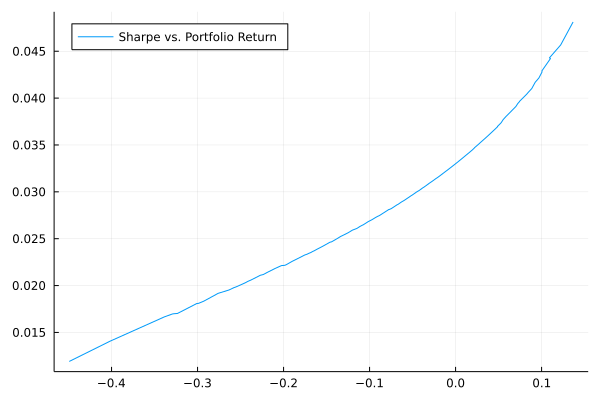

In [8]:
plot(fronteir_sharpes,y,label="Sharpe vs. Portfolio Return",legend=:topleft)